In [1]:
import sys

sys.path.append("..")

In [2]:
from tensorflow import keras

In [3]:
from utils.preprocessing_utils import PreprocessingUtils

In [4]:
from utils.model_wrapper import ModelWrapper

In [5]:
preprocessing_utils = PreprocessingUtils()

Files already exist, skipping...
Loading images and labels...
Images and labels loaded successfully!
Preprocessing labels...
Labels preprocessed successfully!
Loading split data...
Split data loaded successfully!


In [6]:
def build_caffe_net(model_name: str):
    model = keras.models.Sequential(
        name=model_name,
        layers=[
            keras.layers.Conv2D(
                filters=3,
                kernel_size=(11, 11),
                activation="relu",
                input_shape=preprocessing_utils.images.shape[1:],
            ),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=16,
                kernel_size=(5, 5),
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(0.01),
            ),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=96,
                kernel_size=(3, 3),
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(0.01),
            ),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(
                units=2048,
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(0.01),
            ),
            keras.layers.Dense(
                units=2048,
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(0.01),
            ),
            keras.layers.Dense(
                units=preprocessing_utils.num_classes, activation="softmax"
            ),
        ],
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model.summary()

    return model

In [7]:
caffe_net_wrapper = ModelWrapper("CaffeNet", preprocessing_utils=preprocessing_utils)

In [8]:
caffe_net_wrapper.build_model(
    build_fn=build_caffe_net, model_name=caffe_net_wrapper.model_name
)

Building model...
Model: "CaffeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 246, 246, 3)       1092      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 3)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 123, 123, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 16)      1216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                        

In [9]:
caffe_net_wrapper.train_and_save_model_and_history()

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 113.4039 - accuracy: 0.0559
Epoch 1: val_loss improved from inf to 48.95309, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 13s 813ms/step - loss: 113.4039 - accuracy: 0.0559 - val_loss: 48.9531 - val_accuracy: 0.0230 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 48.4954 - accuracy: 0.0309
Epoch 2: val_loss improved from 48.95309 to 35.87443, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 785ms/step - loss: 48.4954 - accuracy: 0.0309 - val_loss: 35.8744 - val_accuracy: 0.0783 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 33.2228 - accuracy: 0.0907
Epoch 3: val_loss improved from 35.87443 to 30.32004, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 860ms/step - loss: 33.2228 - accuracy: 0.0907 - val_loss: 30.3200 - val_accuracy: 0.0461 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 27.3543 - accuracy: 0.1571
Epoch 4: val_loss improved from 30.32004 to 25.73785, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 763ms/step - loss: 27.3543 - accuracy: 0.1571 - val_loss: 25.7379 - val_accuracy: 0.0092 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 22.3136 - accuracy: 0.2087
Epoch 5: val_loss improved from 25.73785 to 21.42697, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 799ms/step - loss: 22.3136 - accuracy: 0.2087 - val_loss: 21.4270 - val_accuracy: 0.0415 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 18.4745 - accuracy: 0.2012
Epoch 6: val_loss improved from 21.42697 to 17.57614, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 793ms/step - loss: 18.4745 - accuracy: 0.2012 - val_loss: 17.5761 - val_accuracy: 0.0461 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 15.3977 - accuracy: 0.2668
Epoch 7: val_loss improved from 17.57614 to 14.90477, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 748ms/step - loss: 15.3977 - accuracy: 0.2668 - val_loss: 14.9048 - val_accuracy: 0.0599 - lr: 0.0010
Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 13.0305 - accuracy: 0.2938
Epoch 8: val_loss improved from 14.90477 to 13.11951, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 755ms/step - loss: 13.0305 - accuracy: 0.2938 - val_loss: 13.1195 - val_accuracy: 0.0645 - lr: 0.0010
Epoch 9/100
9/9 [==============================] - ETA: 0s - loss: 11.5433 - accuracy: 0.2800
Epoch 9: val_loss improved from 13.11951 to 12.18987, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 790ms/step - loss: 11.5433 - accuracy: 0.2800 - val_loss: 12.1899 - val_accuracy: 0.0737 - lr: 0.0010
Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 10.4966 - accuracy: 0.2975
Epoch 10: val_loss improved from 12.18987 to 11.08335, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 800ms/step - loss: 10.4966 - accuracy: 0.2975 - val_loss: 11.0833 - val_accuracy: 0.0783 - lr: 0.0010
Epoch 11/100
9/9 [==============================] - ETA: 0s - loss: 9.4913 - accuracy: 0.3637
Epoch 11: val_loss improved from 11.08335 to 10.33545, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 810ms/step - loss: 9.4913 - accuracy: 0.3637 - val_loss: 10.3354 - val_accuracy: 0.0737 - lr: 0.0010
Epoch 12/100
9/9 [==============================] - ETA: 0s - loss: 8.8469 - accuracy: 0.3838
Epoch 12: val_loss improved from 10.33545 to 9.82085, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 787ms/step - loss: 8.8469 - accuracy: 0.3838 - val_loss: 9.8209 - val_accuracy: 0.1060 - lr: 0.0010
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 8.5674 - accuracy: 0.3948
Epoch 13: val_loss did not improve from 9.82085
9/9 [==============================] - 2s 235ms/step - loss: 8.5674 - accuracy: 0.3948 - val_loss: 9.8480 - val_accuracy: 0.1060 - lr: 0.0010
Epoch 14/100
9/9 [==============================] - ETA: 0s - loss: 8.1255 - accuracy: 0.4442
Epoch 14: val_loss improved from 9.82085 to 9.32874, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 749ms/step - loss: 8.1255 - accuracy: 0.4442 - val_loss: 9.3287 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 15/100
8/9 [=========================>....] - ETA: 0s - loss: 7.7689 - accuracy: 0.4660
Epoch 15: val_loss improved from 9.32874 to 9.02749, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 742ms/step - loss: 7.7769 - accuracy: 0.4629 - val_loss: 9.0275 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 16/100
9/9 [==============================] - ETA: 0s - loss: 7.6056 - accuracy: 0.4867
Epoch 16: val_loss did not improve from 9.02749
9/9 [==============================] - 2s 215ms/step - loss: 7.6056 - accuracy: 0.4867 - val_loss: 9.3067 - val_accuracy: 0.1106 - lr: 0.0010
Epoch 17/100
9/9 [==============================] - ETA: 0s - loss: 7.5316 - accuracy: 0.5074
Epoch 17: val_loss did not improve from 9.02749
9/9 [==============================] - 2s 210ms/step - loss: 7.5316 - accuracy: 0.5074 - val_loss: 9.0472 - val_accuracy: 0.1521 - lr: 0.0010
Epoch 18/100
9/9 [==============================] - ETA: 0s - loss: 7.4206 - accuracy: 0.5091
Epoch 18: val_loss improved from 9.02749 to 8.75096, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 770ms/step - loss: 7.4206 - accuracy: 0.5091 - val_loss: 8.7510 - val_accuracy: 0.1244 - lr: 0.0010
Epoch 19/100
9/9 [==============================] - ETA: 0s - loss: 7.0797 - accuracy: 0.5789
Epoch 19: val_loss improved from 8.75096 to 8.70389, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 775ms/step - loss: 7.0797 - accuracy: 0.5789 - val_loss: 8.7039 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 20/100
9/9 [==============================] - ETA: 0s - loss: 6.9238 - accuracy: 0.5845
Epoch 20: val_loss did not improve from 8.70389
9/9 [==============================] - 2s 215ms/step - loss: 6.9238 - accuracy: 0.5845 - val_loss: 8.9660 - val_accuracy: 0.1106 - lr: 0.0010
Epoch 21/100
8/9 [=========================>....] - ETA: 0s - loss: 6.8995 - accuracy: 0.5867
Epoch 21: val_loss did not improve from 8.70389
9/9 [==============================] - 2s 173ms/step - loss: 6.8944 - accuracy: 0.5874 - val_loss: 8.7064 - val_accuracy: 0.1843 - lr: 0.0010
Epoch 22/100
9/9 [==============================] - ETA: 0s - loss: 6.5862 - accuracy: 0.6473
Epoch 22: val_loss improved from 8.70389 to 8.47497, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 719ms/step - loss: 6.5862 - accuracy: 0.6473 - val_loss: 8.4750 - val_accuracy: 0.1382 - lr: 0.0010
Epoch 23/100
9/9 [==============================] - ETA: 0s - loss: 6.5843 - accuracy: 0.6507
Epoch 23: val_loss did not improve from 8.47497
9/9 [==============================] - 2s 203ms/step - loss: 6.5843 - accuracy: 0.6507 - val_loss: 8.5179 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 24/100
9/9 [==============================] - ETA: 0s - loss: 6.3826 - accuracy: 0.6804
Epoch 24: val_loss improved from 8.47497 to 8.46708, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 750ms/step - loss: 6.3826 - accuracy: 0.6804 - val_loss: 8.4671 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 25/100
9/9 [==============================] - ETA: 0s - loss: 6.1493 - accuracy: 0.7161
Epoch 25: val_loss improved from 8.46708 to 8.39384, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 729ms/step - loss: 6.1493 - accuracy: 0.7161 - val_loss: 8.3938 - val_accuracy: 0.1613 - lr: 0.0010
Epoch 26/100
9/9 [==============================] - ETA: 0s - loss: 6.0600 - accuracy: 0.7105
Epoch 26: val_loss improved from 8.39384 to 8.26230, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 7s 813ms/step - loss: 6.0600 - accuracy: 0.7105 - val_loss: 8.2623 - val_accuracy: 0.1705 - lr: 0.0010
Epoch 27/100
9/9 [==============================] - ETA: 0s - loss: 5.9475 - accuracy: 0.7358
Epoch 27: val_loss did not improve from 8.26230
9/9 [==============================] - 2s 202ms/step - loss: 5.9475 - accuracy: 0.7358 - val_loss: 8.3561 - val_accuracy: 0.1705 - lr: 0.0010
Epoch 28/100
9/9 [==============================] - ETA: 0s - loss: 5.8159 - accuracy: 0.7677
Epoch 28: val_loss did not improve from 8.26230
9/9 [==============================] - 2s 200ms/step - loss: 5.8159 - accuracy: 0.7677 - val_loss: 8.3279 - val_accuracy: 0.1751 - lr: 0.0010
Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 5.6323 - accuracy: 0.7886
Epoch 29: val_loss did not improve from 8.26230
9/9 [==============================] - 2s 201ms/step - loss: 5.6323 - accuracy: 0.7886 - val_loss: 8.5072 - val_accuracy: 0.1244 - lr: 0.0010
Epoch 

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 713ms/step - loss: 5.4846 - accuracy: 0.8120 - val_loss: 7.8998 - val_accuracy: 0.1797 - lr: 5.0000e-04
Epoch 31/100
9/9 [==============================] - ETA: 0s - loss: 5.1040 - accuracy: 0.8886
Epoch 31: val_loss improved from 7.89982 to 7.66622, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 764ms/step - loss: 5.1040 - accuracy: 0.8886 - val_loss: 7.6662 - val_accuracy: 0.1797 - lr: 5.0000e-04
Epoch 32/100
9/9 [==============================] - ETA: 0s - loss: 4.8374 - accuracy: 0.9336
Epoch 32: val_loss improved from 7.66622 to 7.49956, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 732ms/step - loss: 4.8374 - accuracy: 0.9336 - val_loss: 7.4996 - val_accuracy: 0.1751 - lr: 5.0000e-04
Epoch 33/100
9/9 [==============================] - ETA: 0s - loss: 4.6551 - accuracy: 0.9465
Epoch 33: val_loss improved from 7.49956 to 7.46905, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 740ms/step - loss: 4.6551 - accuracy: 0.9465 - val_loss: 7.4691 - val_accuracy: 0.1751 - lr: 5.0000e-04
Epoch 34/100
9/9 [==============================] - ETA: 0s - loss: 4.5177 - accuracy: 0.9572
Epoch 34: val_loss improved from 7.46905 to 7.35992, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 719ms/step - loss: 4.5177 - accuracy: 0.9572 - val_loss: 7.3599 - val_accuracy: 0.1751 - lr: 5.0000e-04
Epoch 35/100
9/9 [==============================] - ETA: 0s - loss: 4.3983 - accuracy: 0.9657
Epoch 35: val_loss did not improve from 7.35992
9/9 [==============================] - 2s 201ms/step - loss: 4.3983 - accuracy: 0.9657 - val_loss: 7.3685 - val_accuracy: 0.1935 - lr: 5.0000e-04
Epoch 36/100
9/9 [==============================] - ETA: 0s - loss: 4.3229 - accuracy: 0.9625
Epoch 36: val_loss improved from 7.35992 to 7.32445, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 758ms/step - loss: 4.3229 - accuracy: 0.9625 - val_loss: 7.3244 - val_accuracy: 0.1475 - lr: 5.0000e-04
Epoch 37/100
9/9 [==============================] - ETA: 0s - loss: 4.2436 - accuracy: 0.9715
Epoch 37: val_loss improved from 7.32445 to 7.21515, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 722ms/step - loss: 4.2436 - accuracy: 0.9715 - val_loss: 7.2151 - val_accuracy: 0.1705 - lr: 5.0000e-04
Epoch 38/100
9/9 [==============================] - ETA: 0s - loss: 4.1705 - accuracy: 0.9796
Epoch 38: val_loss did not improve from 7.21515
9/9 [==============================] - 2s 209ms/step - loss: 4.1705 - accuracy: 0.9796 - val_loss: 7.2506 - val_accuracy: 0.1843 - lr: 5.0000e-04
Epoch 39/100
9/9 [==============================] - ETA: 0s - loss: 4.1271 - accuracy: 0.9766
Epoch 39: val_loss did not improve from 7.21515
9/9 [==============================] - 2s 201ms/step - loss: 4.1271 - accuracy: 0.9766 - val_loss: 7.2868 - val_accuracy: 0.1797 - lr: 5.0000e-04
Epoch 40/100
9/9 [==============================] - ETA: 0s - loss: 4.0885 - accuracy: 0.9669
Epoch 40: val_loss improved from 7.21515 to 7.13095, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 736ms/step - loss: 4.0885 - accuracy: 0.9669 - val_loss: 7.1310 - val_accuracy: 0.1751 - lr: 5.0000e-04
Epoch 41/100
9/9 [==============================] - ETA: 0s - loss: 4.0642 - accuracy: 0.9628
Epoch 41: val_loss did not improve from 7.13095
9/9 [==============================] - 2s 200ms/step - loss: 4.0642 - accuracy: 0.9628 - val_loss: 7.3951 - val_accuracy: 0.1475 - lr: 5.0000e-04
Epoch 42/100
9/9 [==============================] - ETA: 0s - loss: 4.0300 - accuracy: 0.9652
Epoch 42: val_loss did not improve from 7.13095
9/9 [==============================] - 2s 201ms/step - loss: 4.0300 - accuracy: 0.9652 - val_loss: 7.1988 - val_accuracy: 0.1751 - lr: 5.0000e-04
Epoch 43/100
9/9 [==============================] - ETA: 0s - loss: 4.0128 - accuracy: 0.9623
Epoch 43: val_loss did not improve from 7.13095
9/9 [==============================] - 2s 201ms/step - loss: 4.0128 - accuracy: 0.9623 - val_loss: 7.4013 - val_accuracy: 0.1751 - lr: 5

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 776ms/step - loss: 3.7504 - accuracy: 0.9990 - val_loss: 7.0780 - val_accuracy: 0.1843 - lr: 1.2500e-04
Epoch 48/100
9/9 [==============================] - ETA: 0s - loss: 3.7196 - accuracy: 0.9995
Epoch 48: val_loss improved from 7.07803 to 7.03156, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 6s 653ms/step - loss: 3.7196 - accuracy: 0.9995 - val_loss: 7.0316 - val_accuracy: 0.1889 - lr: 1.2500e-04
Epoch 49/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6972 - accuracy: 0.9995
Epoch 49: val_loss did not improve from 7.03156
9/9 [==============================] - 2s 155ms/step - loss: 3.6970 - accuracy: 0.9995 - val_loss: 7.0612 - val_accuracy: 0.1935 - lr: 1.2500e-04
Epoch 50/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6762 - accuracy: 0.9995
Epoch 50: val_loss improved from 7.03156 to 6.97137, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 526ms/step - loss: 3.6760 - accuracy: 0.9995 - val_loss: 6.9714 - val_accuracy: 0.1797 - lr: 1.2500e-04
Epoch 51/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6570 - accuracy: 0.9998
Epoch 51: val_loss did not improve from 6.97137
9/9 [==============================] - 2s 155ms/step - loss: 3.6561 - accuracy: 0.9998 - val_loss: 6.9731 - val_accuracy: 0.1705 - lr: 1.2500e-04
Epoch 52/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6382 - accuracy: 1.0000
Epoch 52: val_loss improved from 6.97137 to 6.93591, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 540ms/step - loss: 3.6380 - accuracy: 1.0000 - val_loss: 6.9359 - val_accuracy: 0.1797 - lr: 1.2500e-04
Epoch 53/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6199 - accuracy: 0.9998
Epoch 53: val_loss did not improve from 6.93591
9/9 [==============================] - 2s 155ms/step - loss: 3.6197 - accuracy: 0.9998 - val_loss: 6.9513 - val_accuracy: 0.1889 - lr: 1.2500e-04
Epoch 54/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6040 - accuracy: 1.0000
Epoch 54: val_loss improved from 6.93591 to 6.91800, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 519ms/step - loss: 3.6042 - accuracy: 1.0000 - val_loss: 6.9180 - val_accuracy: 0.1843 - lr: 1.2500e-04
Epoch 55/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5895 - accuracy: 0.9998
Epoch 55: val_loss improved from 6.91800 to 6.90617, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 546ms/step - loss: 3.5893 - accuracy: 0.9998 - val_loss: 6.9062 - val_accuracy: 0.1843 - lr: 1.2500e-04
Epoch 56/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5739 - accuracy: 1.0000
Epoch 56: val_loss improved from 6.90617 to 6.89372, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 525ms/step - loss: 3.5740 - accuracy: 1.0000 - val_loss: 6.8937 - val_accuracy: 0.1843 - lr: 1.2500e-04
Epoch 57/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5608 - accuracy: 0.9998
Epoch 57: val_loss improved from 6.89372 to 6.86321, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 535ms/step - loss: 3.5605 - accuracy: 0.9998 - val_loss: 6.8632 - val_accuracy: 0.1843 - lr: 1.2500e-04
Epoch 58/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5489 - accuracy: 1.0000
Epoch 58: val_loss did not improve from 6.86321
9/9 [==============================] - 1s 155ms/step - loss: 3.5486 - accuracy: 1.0000 - val_loss: 6.8834 - val_accuracy: 0.1843 - lr: 1.2500e-04
Epoch 59/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5348 - accuracy: 1.0000
Epoch 59: val_loss did not improve from 6.86321
9/9 [==============================] - 1s 156ms/step - loss: 3.5344 - accuracy: 1.0000 - val_loss: 6.8958 - val_accuracy: 0.1843 - lr: 1.2500e-04
Epoch 60/100
9/9 [==============================] - ETA: 0s - loss: 3.5205 - accuracy: 1.0000
Epoch 60: val_loss improved from 6.86321 to 6.84347, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 533ms/step - loss: 3.5205 - accuracy: 1.0000 - val_loss: 6.8435 - val_accuracy: 0.2074 - lr: 1.2500e-04
Epoch 61/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5063 - accuracy: 1.0000
Epoch 61: val_loss did not improve from 6.84347
9/9 [==============================] - 2s 157ms/step - loss: 3.5059 - accuracy: 1.0000 - val_loss: 6.8825 - val_accuracy: 0.1889 - lr: 1.2500e-04
Epoch 62/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4923 - accuracy: 1.0000
Epoch 62: val_loss improved from 6.84347 to 6.82546, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 519ms/step - loss: 3.4924 - accuracy: 1.0000 - val_loss: 6.8255 - val_accuracy: 0.1982 - lr: 1.2500e-04
Epoch 63/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4796 - accuracy: 1.0000
Epoch 63: val_loss improved from 6.82546 to 6.82373, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 637ms/step - loss: 3.4795 - accuracy: 1.0000 - val_loss: 6.8237 - val_accuracy: 0.1982 - lr: 1.2500e-04
Epoch 64/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4664 - accuracy: 1.0000
Epoch 64: val_loss did not improve from 6.82373
9/9 [==============================] - 2s 166ms/step - loss: 3.4660 - accuracy: 1.0000 - val_loss: 6.8329 - val_accuracy: 0.2028 - lr: 1.2500e-04
Epoch 65/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4534 - accuracy: 1.0000
Epoch 65: val_loss improved from 6.82373 to 6.82122, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 664ms/step - loss: 3.4535 - accuracy: 1.0000 - val_loss: 6.8212 - val_accuracy: 0.2028 - lr: 1.2500e-04
Epoch 66/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4447 - accuracy: 1.0000
Epoch 66: val_loss did not improve from 6.82122
9/9 [==============================] - 1s 163ms/step - loss: 3.4444 - accuracy: 1.0000 - val_loss: 6.8485 - val_accuracy: 0.2074 - lr: 1.2500e-04
Epoch 67/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4301 - accuracy: 0.9998
Epoch 67: val_loss did not improve from 6.82122
9/9 [==============================] - 1s 156ms/step - loss: 3.4298 - accuracy: 0.9998 - val_loss: 6.8576 - val_accuracy: 0.1982 - lr: 1.2500e-04
Epoch 68/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4171 - accuracy: 1.0000
Epoch 68: val_loss did not improve from 6.82122
9/9 [==============================] - 1s 156ms/step - loss: 3.4168 - accuracy: 1.0000 - val_loss: 6.8263 - val_accuracy: 0.1982 - lr: 1

In [10]:
caffe_net_wrapper.load_model_and_history()

Loading model from "../../artifacts/models/CaffeNet.h5"...
Model loaded successfully!
Loading history from "../../artifacts/model_histories/history_CaffeNet"...
History loaded successfully!


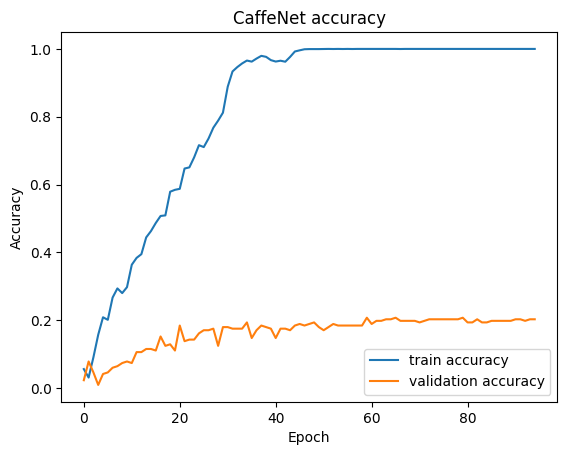

In [11]:
caffe_net_wrapper.plot_accuracy()

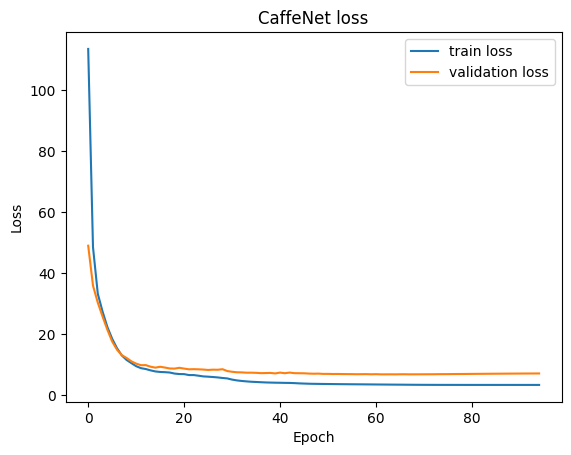

In [12]:
caffe_net_wrapper.plot_loss()

20/20 [==============================] - 1s 14ms/step - loss: 7.1124 - accuracy: 0.2246
Loss: 7.1124
Accuracy: 0.2246
20/20 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.09      0.11        23
           1       0.21      0.16      0.18        25
           2       0.42      0.42      0.42        52
           3       0.21      0.18      0.19        38
           4       0.25      0.11      0.15        27
           5       0.14      0.17      0.15        35
           6       0.18      0.18      0.18        45
           7       0.00      0.00      0.00        10
           8       0.14      0.17      0.15        12
           9       0.50      0.27      0.35        11
          10       0.10      0.09      0.09        23
          11       0.31      0.35      0.33        26
          12       0.26      0.25      0.25        32
          13       0.12      0.13      0.12      

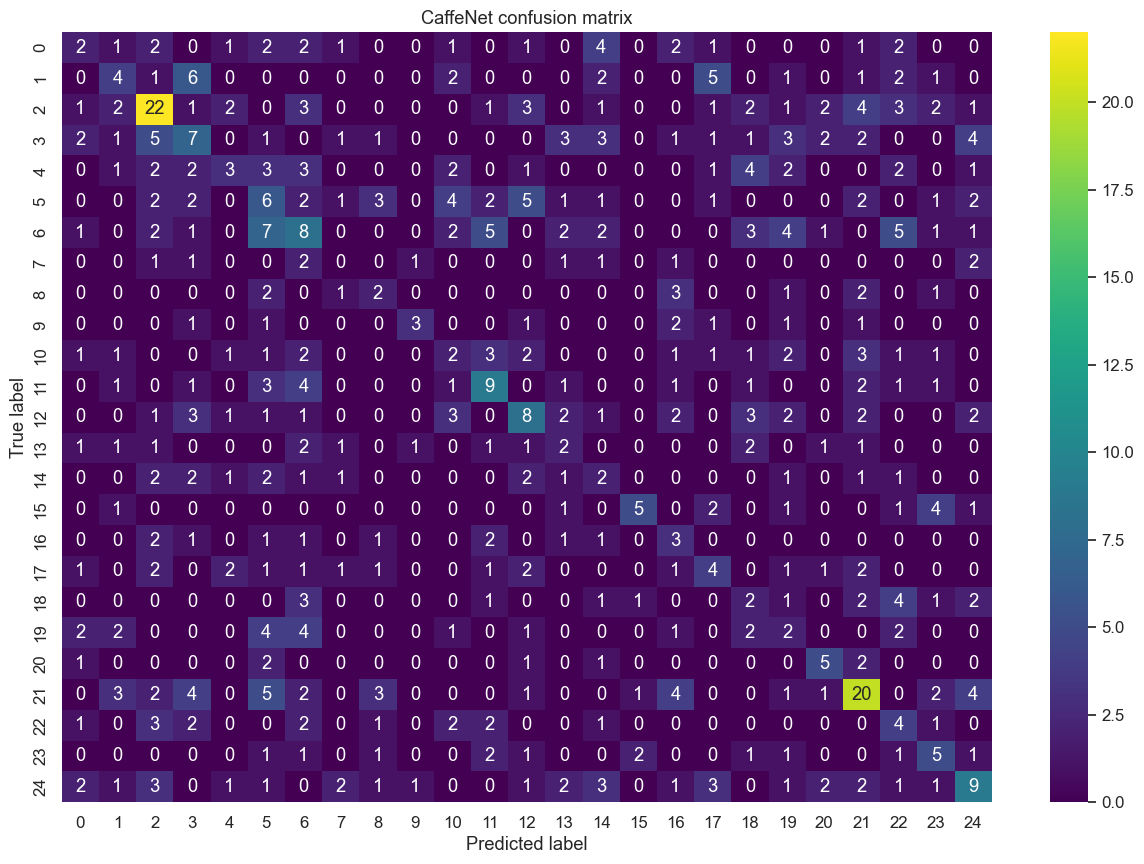

In [13]:
caffe_net_wrapper.display_evaluation_results()